# Import Data and Train Model


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
from torchvision.transforms import ToTensor, Lambda
from transformers import get_scheduler, AdamW
from datasets import load_metric

import numpy as np
from scipy.io import wavfile
from scipy.fft import fft, fftfreq, fftshift
from scipy.fftpack import dct
import IPython.display
import librosa

import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import pandas as pd;
import numpy as np
import math

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import mne
import mne.channels
from tqdm.auto import tqdm


c:\Users\loicl\Documents\UniWork\Year 3\Dissertation\TinyML-for-Epileptic-Seizures\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Data: Create Dataset


### Load Absence Seizure Data


In [209]:
class AbsenceDataset(Dataset):
    def __init__(self, file_path, transform=None, target_transform=None):
        self.x, self.y = self.data_get(file_path)
        self.n_samples = len(self.x)

        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, idx):
        sample_x, sample_y = self.x[idx], self.y[idx]

        if self.transform:
            sample_x = self.transform(sample_x)

        if self.target_transform:
            sample_y = self.target_transform(sample_y)

        return sample_x.float(), sample_y.float()

    def __len__(self):
        return self.n_samples

    def data_get(self, file_path):
        data = pd.read_csv(file_path)
        x_loaded, y_loaded = [], []
        for index, row in data.iterrows():
            a = np.load(row["labels"])
            for i, v in enumerate(a):
                a[i] = int(v)
            y_loaded.append(a)

            x_loaded.append(np.load(row["data"]))

        continuous_x = np.concatenate(x_loaded, axis=0)
        continuous_y = np.concatenate(y_loaded, axis=0)

        return continuous_x, continuous_y

In [255]:
%%capture
# Load the dataset
dataset = AbsenceDataset(
    "processed_data/absence/five_channels_il_075/epochs_files.csv",
    transform=torch.tensor,
    target_transform=torch.tensor,
)
dataset.y = dataset.y.astype(int)

In [256]:
dataset.x.shape

(4141, 5, 1000)

# Split Data

70%, 20%, 10%


In [257]:
dataset_len = len(dataset)
dataset_len

4141

In [258]:
if (
    int(dataset_len * 0.7) + int(dataset_len * 0.2) + int(dataset_len * 0.1)
) != dataset_len:
    train_set, eval_set, test_set = random_split(
        dataset,
        [
            math.ceil(dataset_len * 0.7),
            int(dataset_len * 0.2),
            int(dataset_len * 0.1),
        ],
    )
else:
    train_set, eval_set, test_set = random_split(
        dataset,
        [
            int(dataset_len * 0.1),
            int(dataset_len * 0.7),
            int(dataset_len * 0.2),
        ],
    )

print(f"Train Split: {len(train_set)}")
print(f"Eval Split: {len(eval_set)}")
print(f"Test Split: {len(test_set)}")
print(f"Total: {len(train_set) + len(eval_set) + len(test_set)}")

Train Split: 2899
Eval Split: 828
Test Split: 414
Total: 4141


In [298]:
train_set.dataset.x[train_set.indices].shape, train_set.dataset.y[
    train_set.indices
].shape

((2899, 5, 1000), (2899,))

## Random Undersampling


In [260]:
bk, sz = 0, 0
for i, v in enumerate(train_set.dataset.y[train_set.indices]):
    if v == 1:
        sz += 1
    else:
        bk += 1

print(f"Background: {bk} // Absence Seizure: {sz}")

Background: 2772 // Absence Seizure: 127


In [261]:
shape = train_set.dataset.x[train_set.indices].shape
data_reshaped = train_set.dataset.x[train_set.indices]
data_reshaped = np.reshape(data_reshaped, (shape[0], shape[1] * shape[2]))
data_reshaped.shape

(2899, 5000)

In [262]:
rand_us = RandomUnderSampler(random_state=42)
train_set_x, train_set_y = rand_us.fit_resample(
    data_reshaped, train_set.dataset.y[train_set.indices]
)

In [263]:
train_set_x = np.reshape(train_set_x, (train_set_x.shape[0], shape[1], shape[2]))
val_set_x = 
train_set_x.shape

(254, 5, 1000)

In [264]:
bk, sz = 0, 0
for i, v in enumerate(train_set_y):
    if v == 1:
        sz += 1
    else:
        bk += 1

print(f"Background: {bk} // Absence Seizure: {sz}")

Background: 127 // Absence Seizure: 127


# STFT


Create STFT


In [277]:
window = "hann"
n_fft = 24
hop_length = int(n_fft / 4)

# Train
stft_channel_data = []
for i, channels in enumerate(train_set_x):
    stft_channel_data.append(librosa.stft(channels, n_fft=n_fft, hop_length=hop_length, window=window))
stft_channel_data = np.array(stft_channel_data)

# Val
val_stft_channel_data = []:
for i, channels in enumerate(train_set_x):
    stft_channel_data.append(librosa.stft(channels, n_fft=n_fft, hop_length=hop_length, window=window))
stft_channel_data = np.array(stft_channel_data)

stft_channel_data.shape

(254, 5, 13, 167)

Display STFT


C:\Users\loicl\AppData\Local\Temp\ipykernel_24172\3552689749.py:3: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  Xdb = librosa.amplitude_to_db(stft_channel_data[y][0])


1

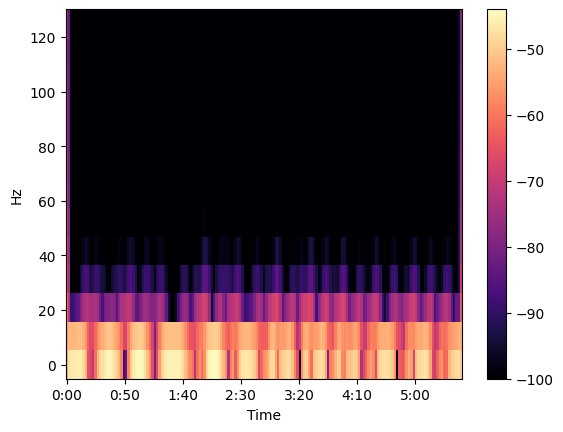

In [295]:
y = 233

Xdb = librosa.amplitude_to_db(stft_channel_data[y][0])
# plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=250, x_axis="time", y_axis="hz")
plt.colorbar()

train_set_y[y]

# Remake Dataset


In [26]:
class BalancedDataset(Dataset):
    def __init__(self, data, transform=None, target_transform=None):
        self.x, self.y = data
        self.n_samples = len(self.x)

        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, idx):
        sample_x, sample_y = self.x[idx], self.y[idx]

        if self.transform:
            sample_x = self.transform(sample_x)

        if self.target_transform:
            sample_y = self.target_transform(sample_y)

        return sample_x.float(), sample_y.float()

    def __len__(self):
        return self.n_samples

In [27]:
new_balanced_train_dataset = BalancedDataset(
    (mfcc, train_set_y), transform=torch.tensor, target_transform=torch.tensor
)
mfcc_eval_dataset = BalancedDataset(
    (eval_mfcc, eval_set.dataset.y[eval_set.indices]),
    transform=torch.tensor,
    target_transform=torch.tensor,
)

# Visualize Data


In [ ]:
# Plot 3 of each class
fig, axs = plt.subplots(2, 3, figsize=(20, 5))
fig.suptitle(
    "3 samples of each class: Absence Seizure and Background - Plotted as images with values scaled to 0-255"
)

c1 = 0
c0 = 0

for i, v in enumerate(train_set.dataset.y[train_set.indices]):
    if v == 0 and c0 < 3:
        clone = train_set.dataset.x[train_set.indices][i]
        max_pixel = 0
        min_pixel = 0
        for m, b in enumerate(clone):
            for j, n in enumerate(clone[m]):
                if n > max_pixel:
                    max_pixel = n
                if n < min_pixel:
                    min_pixel = n

        for m, b in enumerate(clone):
            for j, n in enumerate(clone[m]):
                a = clone[m][j] - min_pixel
                b = 255 / (max_pixel - min_pixel)
                norm = a * b
                if norm > 255:
                    norm = 255
                if norm < 0:
                    norm = 0
                clone[m][j] = norm

        # Increase image size for better visibility if needed
        clone = np.repeat(clone, 50, axis=0)

        axs[0, c0].imshow(clone, cmap="gray")
        axs[0, c0].set_title(f"Label 0: Background // Data Index: {i}")
        axs[0, c0].set_yticks([])
        axs[0, c0].set_xticks([0, 1000])
        axs[0, c0].set_xlabel("Data Points Per Window")

        c0 += 1

    if v == 1 and c1 < 3:
        clone = train_set.dataset.x[train_set.indices][i]
        max_pixel = 0
        min_pixel = 0

        for m, b in enumerate(clone):
            for j, n in enumerate(clone[m]):
                if n > max_pixel:
                    max_pixel = n
                if n < min_pixel:
                    min_pixel = n

        for m, b in enumerate(clone):
            for j, n in enumerate(clone[m]):
                a = clone[m][j] - min_pixel
                b = 255 / (max_pixel - min_pixel)
                norm = a * b
                if norm > 255:
                    norm = 255
                if norm < 0:
                    norm = 0
                clone[m][j] = norm

        # Increase image size for better visibility if needed
        clone = np.repeat(clone, 50, axis=0)

        axs[1, c1].imshow(clone, cmap="gray")
        axs[1, c1].set_title(f"Label 1: Absence Seizure // Data Index: {i}")
        axs[1, c1].set_yticks([])
        axs[1, c1].set_xticks([0, 1000])
        axs[1, c1].set_xlabel("Data Points Per Window")

        c1 += 1

    if c1 == 3 and c0 == 3:
        break

    # new_img = Image.fromarray(clone)

In [ ]:
# Plot 3 of each class
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
fig.suptitle("3 samples of each class")
c0 = 0
c1 = 0
for i, v in enumerate(train_set.dataset.x[train_set.indices]):
    if c0 < 3 and train_set.dataset.y[train_set.indices][i] == 0:
        axs[0, c0].plot(train_set.dataset.x[train_set.indices][i][0], label="Channel 1")
        axs[0, c0].plot(train_set.dataset.x[train_set.indices][i][1], label="Channel 2")
        axs[0, c0].plot(train_set.dataset.x[train_set.indices][i][2], label="Channel 3")
        axs[0, c0].plot(train_set.dataset.x[train_set.indices][i][3], label="Channel 4")
        axs[0, c0].plot(train_set.dataset.x[train_set.indices][i][4], label="Channel 5")
        axs[0, c0].legend(loc="upper right")
        axs[0, c0].set_title(f"Label 0: Background // Data Index: {i}")
        c0 += 1
    elif c1 < 3 and train_set.dataset.y[train_set.indices][i] == 1:
        axs[1, c1].plot(train_set.dataset.x[train_set.indices][i][0], label="Channel 1")
        axs[1, c1].plot(train_set.dataset.x[train_set.indices][i][1], label="Channel 2")
        axs[1, c1].plot(train_set.dataset.x[train_set.indices][i][2], label="Channel 3")
        axs[1, c1].plot(train_set.dataset.x[train_set.indices][i][3], label="Channel 4")
        axs[1, c1].plot(train_set.dataset.x[train_set.indices][i][4], label="Channel 5")
        axs[1, c1].legend(loc="upper right")
        axs[1, c1].set_title(f"Label 1: Absence Seizure // Data Index: {i}")
        c1 += 1

    if c0 == 3 and c1 == 3:
        break
plt.show()

In [ ]:
# Plot 3 of each class
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
fig.suptitle("3 samples of each class")
c0 = 0
c1 = 0
for i, v in enumerate(x_train_reshaped):
    if c0 < 3 and train_set.dataset.y[train_set.indices][i] == 0:
        axs[0, c0].plot(x_train_reshaped[i])
        axs[0, c0].set_title(f"Label 0: Background // Data Index: {i}")
        c0 += 1
    elif c1 < 3 and train_set.dataset.y[train_set.indices][i] == 1:
        axs[1, c1].plot(x_train_reshaped[i])
        axs[1, c1].set_title(f"Label 1: Absence Seizure // Data Index: {i}")
        c1 += 1

    if c0 == 3 and c1 == 3:
        break
plt.show()

# DataLoaders


In [28]:
train_dataloader = DataLoader(
    dataset=new_balanced_train_dataset,
    batch_size=1,
    shuffle=True,
)
eval_dataloader = DataLoader(dataset=mfcc_eval_dataset, batch_size=1, shuffle=True)
test_dataloader = DataLoader(dataset=test_set, batch_size=1, shuffle=True)

# Model


## Model 1: CNN


### 1D Model


In [29]:
class AbnormalNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # Input 5 Channels
        self.CNN1 = nn.Conv1d(in_channels=1, out_channels=20, kernel_size=3)
        self.MaxPool1 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.CNN2 = nn.Conv1d(in_channels=20, out_channels=60, kernel_size=3)
        self.MaxPool2 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.CNN3 = nn.Conv1d(in_channels=60, out_channels=1, kernel_size=2)
        self.MaxPool3 = nn.MaxPool1d(kernel_size=2, stride=1)

        self.fc1 = nn.Linear(in_features=6, out_features=100)
        self.fc2 = nn.Linear(in_features=100, out_features=50)
        self.output = nn.Linear(in_features=50, out_features=1)

    def forward(self, x):
        x = F.relu(self.CNN1(x))
        x = self.MaxPool1(x)

        x = F.relu(self.CNN2(x))
        x = self.MaxPool2(x)

        x = F.relu(self.CNN3(x))
        x = self.MaxPool3(x)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.output(x)
        return x


# Set device to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model
model = AbnormalNeuralNetwork().to(device)

# Set optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# Calculate number of parameters in model
n_params = 0
for x in model.parameters():
    n_params += len(torch.flatten(x))
print(f"Number of parameters in model: {n_params:,}")

# Print Model
model = model.to(device)

Number of parameters in model: 9,662


### 2D Model


In [ ]:
class AbnormalNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # Input 5 Channels
        self.CNN1 = nn.Conv2d(
            in_channels=1, out_channels=17, kernel_size=(3, 3), padding=(1, 0)
        )
        self.MaxPool1 = nn.MaxPool2d(kernel_size=(3, 3), stride=2)

        self.CNN2 = nn.Conv2d(
            in_channels=17, out_channels=29, kernel_size=(3, 3), padding=(1, 0)
        )
        self.MaxPool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)

        self.CNN3 = nn.Conv2d(
            in_channels=29, out_channels=41, kernel_size=(3, 3), padding=(1, 0)
        )
        self.MaxPool3 = nn.MaxPool2d(kernel_size=(1, 1), stride=2)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(5043, 1024)
        self.dropout1 = nn.Dropout(p=0.3)

        self.fc2 = nn.Linear(1024, 1024)
        self.dropout2 = nn.Dropout(p=0.3)

        # Output Layer
        self.output = nn.Linear(in_features=1024, out_features=1)

    def forward(self, x):
        x = F.relu(self.CNN1(x))
        x = self.MaxPool1(x)

        x = F.relu(self.CNN2(x))
        x = self.MaxPool2(x)

        x = F.relu(self.CNN3(x))
        x = self.MaxPool3(x)

        x = self.flatten(x)

        x = F.relu(self.fc1(x))
        x = self.dropout1(x)

        x = F.relu(self.fc2(x))
        x = self.dropout2(x)

        x = self.output(x)
        return x


# Calculate number of parameters in model
n_params = 0
for x in model.parameters():
    n_params += len(torch.flatten(x))
print(f"Number of parameters in model: {n_params:,}")

# Initialize model
model = AbnormalNeuralNetwork().to(device)

# Print Model
model = model.to(device)
model

# Train


## Model 2: Linear


### 1


In [ ]:
class LinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(39, 78)
        self.linear2 = nn.Linear(78, 78)
        self.output = nn.Linear(78, 1)

    def forward(self, out):
        out = F.relu(self.linear1(out))
        out = F.relu(self.linear2(out))
        out = self.output(out)
        return out


model = LinearRegression().to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

n_params = 0
for x in model.parameters():
    n_params += len(torch.flatten(x))
print(f"Number of parameters in model: {n_params:,}")

### 2


## Training Loop


### Print Inputs


In [30]:
# Plot distribution of the dataset before balancing
# 0 - Background epoch
# 1 - Absence seizure epoch

bk = 0
sz = 0
for i, v in enumerate(train_dataloader):
    if v[1].squeeze() == torch.tensor([1.0]):
        sz += 1
    else:
        bk += 1

print(f"Train // Background: {bk} // Absence Seizure: {sz}")

bk = 0
sz = 0
for i, v in enumerate(eval_dataloader):
    if v[1].squeeze() == torch.tensor([1.0]):
        sz += 1
    else:
        bk += 1

print(f"Validation // Background: {bk} // Absence Seizure: {sz}")

Train // Background: 139 // Absence Seizure: 139
Validation // Background: 792 // Absence Seizure: 36


In [ ]:
ones = []
for i, v in enumerate(train_dataloader):
    if v[1].squeeze() == torch.tensor([1]):
        ones.append(i)
print(ones)

c = 0
for i, v in enumerate(train_dataloader):
    if c == 20:
        first_input = v[0].squeeze()
        first_label = v[1].squeeze()
    if c == 21:
        first_input2 = v[0].squeeze()
        first_label2 = v[1].squeeze()
        break
    c += 1

fig, axs = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle("First 2 samples of the dataset")
axs[0].plot(first_input)
axs[0].set_title(f"Label: {first_label}")
axs[1].plot(first_input2)
axs[1].set_title(f"Label: {first_label2}")

### Training


In [31]:
for i, v in enumerate(eval_dataloader):
    first_input = v[0]
    first_label = v[1]
    break

print(first_input.shape, first_label)

for i, v in enumerate(train_dataloader):
    first_input = v[0]
    first_label = v[1]
    break

print(first_input.shape, first_label)

torch.Size([1, 39]) tensor([0.])
torch.Size([1, 39]) tensor([1.])


In [39]:
num_epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
scheduler = get_scheduler(
    "linear",
    optimizer,
    num_warmup_steps=0,
    num_training_steps=num_epochs * len(train_dataloader),
)

In [40]:
progress_bar = tqdm(range(num_epochs * len(train_dataloader)))

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        outputs = outputs.squeeze(-1)  # Not needed for LR
        loss = loss_fn(outputs, labels)
        loss.backward()

        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

100%|██████████| 27800/27800 [05:05<00:00, 90.89it/s] 


In [46]:
metric = load_metric("glue", "mrpc")
model.eval()
tp, fp, tn, fn = 0, 0, 0, 0
results_list = []
for batch in eval_dataloader:
    inputs, labels = batch
    inputs, labels = inputs.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        outputs = outputs.squeeze(-1)  # Not needed for LR

    results_list.append(outputs)
    if outputs > 0.5:
        if labels == 1:
            tp += 1
        else:
            fp += 1
    else:
        if labels == 0:
            tn += 1
        else:
            fn += 1

    # logits = outputs.logits
    # predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=outputs, references=labels)

results = metric.compute()

c:\Users\loicl\Documents\UniWork\Year 3\Dissertation\TinyML-for-Epileptic-Seizures\.venv\Lib\site-packages\datasets\load.py:756: FutureWarning: The repository for glue contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/glue/glue.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


True Positives: 36
False Positives: 792
True Negatives: 0
False Negatives: 0
[tensor([0.5000], device='cuda:0'), tensor([0.5000], device='cuda:0'), tensor([0.5000], device='cuda:0'), tensor([0.5000], device='cuda:0'), tensor([0.5000], device='cuda:0'), tensor([0.5000], device='cuda:0'), tensor([0.5000], device='cuda:0'), tensor([0.5000], device='cuda:0'), tensor([0.5000], device='cuda:0'), tensor([0.5000], device='cuda:0'), tensor([0.5000], device='cuda:0'), tensor([0.5000], device='cuda:0'), tensor([0.5000], device='cuda:0'), tensor([0.5000], device='cuda:0'), tensor([0.5000], device='cuda:0'), tensor([0.5000], device='cuda:0'), tensor([0.5000], device='cuda:0'), tensor([0.5000], device='cuda:0'), tensor([0.5000], device='cuda:0'), tensor([0.5000], device='cuda:0'), tensor([0.5000], device='cuda:0'), tensor([0.5000], device='cuda:0'), tensor([0.5000], device='cuda:0'), tensor([0.5000], device='cuda:0'), tensor([0.5000], device='cuda:0'), tensor([0.5000], device='cuda:0'), tensor([0.50

c:\Users\loicl\Documents\UniWork\Year 3\Dissertation\TinyML-for-Epileptic-Seizures\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:271: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


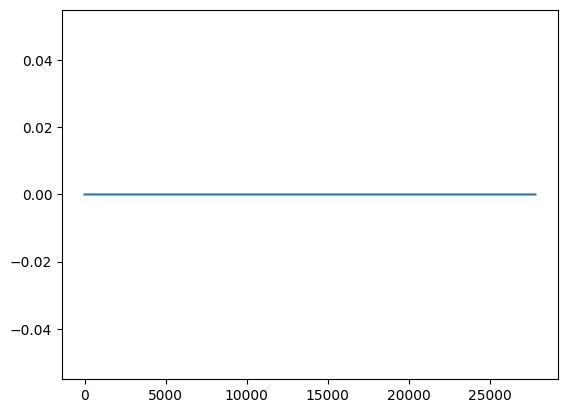

In [49]:
print(f"True Positives: {tp}")
print(f"False Positives: {fp}")
print(f"True Negatives: {tn}")
print(f"False Negatives: {fn}")
print(results_list)
print(results)

# Plot schedular graph

In [ ]:
# Plot losses
plt.plot(range(len(loss_track_train)), loss_track_train, label="Training Loss")
plt.plot(range(len(loss_track_valid)), loss_track_valid, label="Validation Loss")

plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")


plt.show()

In [ ]:
torch.save(model.state_dict(), "model_{}".format("first_test"))